# Radial Relative Velocity Comparison

This notebook provides a comparison between DNS (Direct Numerical Simulation) radial relative velocities and the model predictions from the particula library.

In this notebook, we replicate and compare the collision kernels from the DNS data as presented in Figure 13 of the following reference:

**Reference:**
Ayala, O., Rosa, B., & Wang, L. P. (2008). *Effects of turbulence on the geometric collision rate of sedimenting droplets. Part 2. Theory and parameterization*. New Journal of Physics, 10. https://doi.org/10.1088/1367-2630/10/7/075016

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import particula as par

from particula.dynamics.coagulation.turbulent_dns_kernel.radial_velocity_module import (
    get_radial_relative_velocity_dz2002,
)
from particula.dynamics.coagulation.turbulent_dns_kernel.sigma_relative_velocity_ao2008 import (
    get_relative_velocity_variance,
)

# data from AO2008 Fig. 13
data = np.array(
    [
        [10.06195787, 5.602409639],
        [15.01858736, 5.13253012],
        [19.97521685, 3.506024096],
        [25.11771995, 2.096385542],
        [27.53407683, 1.265060241],
        [30.01239157, 0.108433735],
        [32.49070632, 1.518072289],
        [40.04956629, 5.746987952],
        [49.96282528, 11.85542169],
        [60, 19.37349398],
    ]
)

## Parameter Definition and Viscosity Calculation

Define the particle radii and other parameters such as temperature, particle density, and fluid density.
These parameters are essential for calculating various par.particles and velocities.
Calculate the dynamic and kinematic viscosity of the fluid, as well as turbulence par.particles like Kolmogorov time.
These are used in subsequent calculations of particle par.particles.

In [2]:
particle_radius = np.linspace(10e-6, 60e-6, 50)
temperature = 273  # Temperature in Kelvin
particle_density = 1000  # Particle density in kg/m³
fluid_density = 1.0  # Fluid (air) density in kg/m³

# Convert turbulent dissipation rate from cm²/s³ to m²/s³
turbulent_dissipation = 400 * par.util.get_unit_conversion("cm^2/s^3", "m^2/s^3")
reynolds_lambda = 72.41  # Example value


dynamic_viscosity = par.gas.get_dynamic_viscosity(temperature)
kinematic_viscosity = par.gas.get_kinematic_viscosity(
    dynamic_viscosity, fluid_density
)
kolmogorov_time = par.gas.get_kolmogorov_time(
    kinematic_viscosity=kinematic_viscosity,
    turbulent_dissipation=turbulent_dissipation,
)

## Particle Inertia and Settling Velocity

Calculate the particle inertia time, which is a measure of how quickly particles respond to changes in the surrounding fluid flow.
Also, calculate the settling velocity of particles using the drag model, which involves calculating the mean free path, Knudsen number, and slip correction factor.

In [3]:
particle_inertia_time = par.particles.get_particle_inertia_time(
    particle_radius=particle_radius,
    particle_density=particle_density,
    fluid_density=fluid_density,
    kinematic_viscosity=kinematic_viscosity,
)

mean_free_path = par.gas.get_molecule_mean_free_path(
    temperature=temperature, dynamic_viscosity=dynamic_viscosity
)
# 2. Slip correction factors
knudsen_number = par.particles.get_knudsen_number(
    mean_free_path=mean_free_path, particle_radius=particle_radius
)
slip_correction_factor = par.particles.get_cunningham_slip_correction(knudsen_number)
particle_settling_velocity = (
    par.particles.get_particle_settling_velocity_with_drag(
        particle_radius=particle_radius,
        particle_density=particle_density,
        fluid_density=fluid_density,
        dynamic_viscosity=dynamic_viscosity,
        slip_correction_factor=slip_correction_factor,
        re_threshold=0.1,
    )
)

## Turbulence and Velocity Calculations

Calculate the root mean square (RMS) velocity of the fluid, which is used to determine the intensity of turbulence in the fluid.
Additionally, calculate various turbulence scales such as the Taylor microscale, Eulerian integral length, and Lagrangian integral time.
These scales are important for understanding the turbulence characteristics.

In [4]:
fluid_rms_velocity = par.gas.get_fluid_rms_velocity(
    re_lambda=reynolds_lambda,
    kinematic_viscosity=kinematic_viscosity,
    turbulent_dissipation=turbulent_dissipation,
)

taylor_microscale = par.gas.get_taylor_microscale(
    fluid_rms_velocity=fluid_rms_velocity,
    kinematic_viscosity=kinematic_viscosity,
    turbulent_dissipation=turbulent_dissipation,
)
eulerian_integral_length = par.gas.get_eulerian_integral_length(
    fluid_rms_velocity=fluid_rms_velocity,
    turbulent_dissipation=turbulent_dissipation,
)
lagrangian_integral_time = par.gas.get_lagrangian_integral_time(
    fluid_rms_velocity=fluid_rms_velocity,
    turbulent_dissipation=turbulent_dissipation,
)
normalized_accel_variance = (
    par.gas.get_normalized_accel_variance_ao2008(
        re_lambda=reynolds_lambda
    )
)
lagrangian_taylor_microscale_time = (
    par.gas.get_lagrangian_taylor_microscale_time(
        kolmogorov_time=kolmogorov_time,
        re_lambda=reynolds_lambda,
        accel_variance=normalized_accel_variance,
    )
)

## Collision and Velocity Dispersion

Calculate the collisional radius, which is the sum of the radii of two colliding particles.
This is used in the calculation of collision rates and velocities.
Also, calculate the velocity dispersion, which is a measure of the spread of particle velocities.
This is used to compute the radial relative velocities.

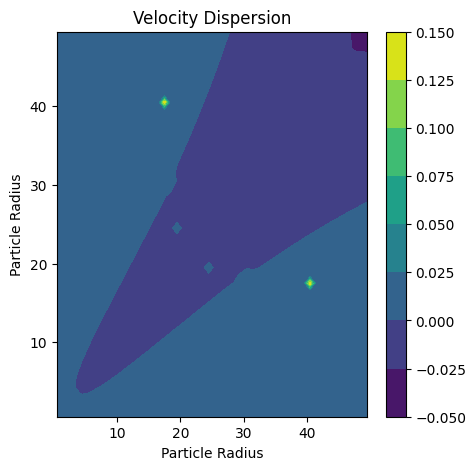

In [5]:
collisional_radius = (
    particle_radius[:, np.newaxis] + particle_radius[np.newaxis, :]
)

velocity_dispersion = get_relative_velocity_variance(
    fluid_rms_velocity=fluid_rms_velocity,
    collisional_radius=collisional_radius,
    particle_inertia_time=particle_inertia_time,
    particle_velocity=particle_settling_velocity,
    taylor_microscale=taylor_microscale,
    eulerian_integral_length=eulerian_integral_length,
    lagrangian_integral_time=lagrangian_integral_time,
    lagrangian_taylor_microscale_time=lagrangian_taylor_microscale_time,
)

fig, ax = plt.subplots(figsize=(5, 5))
graph = ax.contourf(velocity_dispersion, cmap="viridis", origin="lower")
ax.set_xlabel("Particle Radius")
ax.set_ylabel("Particle Radius")
ax.set_title("Velocity Dispersion")
plt.colorbar(graph)
plt.show()

In [6]:
def radial_velocity_calc(velocity_dispersion, particle_inertia_time):
    # Check if velocity_dispersion contains NaN
    if np.isnan(velocity_dispersion).any():
        print("Warning: velocity_dispersion contains NaN")

    # Compute Radial Relative Velocities
    radial_relative_velocity = get_radial_relative_velocity_dz2002(
        velocity_dispersion,
        particle_inertia_time,
    )

    return radial_relative_velocity

## Radial Relative Velocities and Plotting

Define a function to compute the radial relative velocities using the velocity dispersion and particle inertia time.
This function includes a check for NaN values in the velocity dispersion.
Plot the radial relative velocities for different particle radii, including both the model predictions and the DNS data for comparison.
Additionally, create an image plot of the radial relative velocity using a contour plot to provide a visual representation of the velocity field.

In [7]:
radial_relative_velocity = radial_velocity_calc(
    np.abs(velocity_dispersion), particle_inertia_time
)

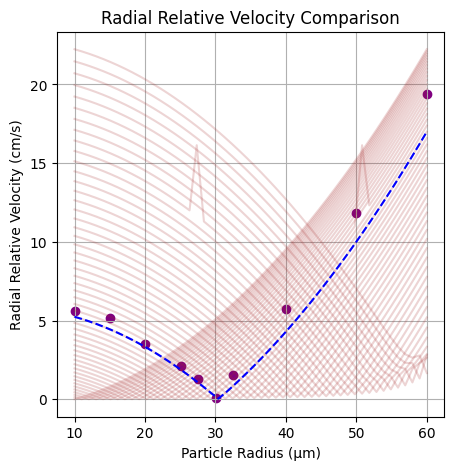

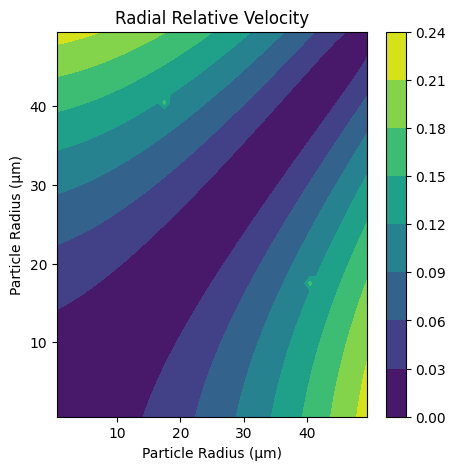

In [8]:
index = np.argmin(np.abs(particle_radius - 30e-6))
fig, ax = plt.subplots(figsize=(5, 5))
# Plot the average radial relative velocity over all particle pairs
ax.plot(
    particle_radius * 1e6,
    radial_relative_velocity * 100,
    label="Model Prediction",
    color="brown",
    alpha=0.2,
)
ax.plot(
    particle_radius * 1e6,
    radial_relative_velocity[:, index] * 100,
    label="Model Prediction at 30 µm",
    color="blue",
    linestyle="--",
)
ax.scatter(data[:, 0], data[:, 1], label="DNS Data", color="purple")
ax.set_xlabel("Particle Radius (µm)")
ax.set_ylabel("Radial Relative Velocity (cm/s)")
ax.set_title("Radial Relative Velocity Comparison")
ax.grid(True)
plt.show()

fig, ax = plt.subplots(figsize=(5, 5))
graph = ax.contourf(radial_relative_velocity, cmap="viridis", origin="lower")
ax.set_xlabel("Particle Radius (µm)")
ax.set_ylabel("Particle Radius (µm)")
ax.set_title("Radial Relative Velocity")
plt.colorbar(graph)
plt.show()

## Summary

This notebook provides a comparison of the radial relative velocities between DNS data and model predictions.

There are non-realistic jumps in the `particula` library predictions, which are not present in the DNS data. These are due to errors in the calculation of the settling velocity, which should be improved in future versions of the library.